In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

from IPython.display import display, clear_output
import logging
logging.getLogger('tensorflow').disabled = True



In [2]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
import matplotlib.pyplot as plt

In [3]:
import sys
from stm.stm import STM, RBF2DInterpolation

# Training a GTM with the GTM object

### Constants and Plots

In [4]:
# Model constants ----

x_train = 2*x_train/255 - 1
x_test = 2*x_train/255 - 1
inp_num = x_train.shape[1:]
inp_side = inp_num[0]
out_num = 10**2
out_side = int(np.sqrt(out_num))
initial_lr = 0.05
initial_sigma = out_side//8
min_sigma =0.7

x = np.arange(out_side)
X, Y = np.meshgrid(x, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

points = np.array([
    [1, 3],
    [1, 6],
    [3, 1],
    [3, 8],
    [4.5, 3],
    [4.5, 6],
    [6, 1],
    [6, 8],
    [8, 3],
    [8, 6]])

def gauss(d, s): return np.exp(-0.5*(s**-2)*d**2)

# Scheduling constants ----

x_train = x_train

decay_window = 60.0
data = x_train
data_num = x_train.shape[0]
batches_num = 10
batch_size = data_num // batches_num
epochs = 200
idcs = np.arange(data_num)
idx = 54

In [5]:
# initialize plots ----
plt.ioff()

fig = plt.figure(figsize=(18, 10))

# The current digit image
ax1 = fig.add_subplot(131, aspect="equal")
digit = ax1.imshow(data[idx],vmin=-1, vmax=1, cmap=plt.cm.Greys)
ax1.set_axis_off()

# The weights plotted as digit prototypes
ax2 = fig.add_subplot(132, aspect="equal")
w = ax2.imshow(np.random.rand(10, 10),vmin=-1, vmax=1, cmap=plt.cm.Greys)   
ax2.set_axis_off()

# The grid of target positions of prototypes
ppoints = points.copy()
ppoints[:,1] = 9 - ppoints[:,1]
ax3 = fig.add_subplot(133, aspect="equal")
_ = ax3.scatter(*ppoints.T)
for i,p in enumerate(ppoints):
    _ = ax3.text(*(p+0.2), "%d" % i, fontsize=20)
_ = ax3.set_xlim([0,9])
_ = ax3.set_ylim([0,9])

### Model

In [6]:
# Model graph ----

dists = keras.layers.Input(shape = [out_num])
stm = STM(out_num, initial_sigma, name="stm")

# the graph for the GTM
inp = keras.layers.Input(shape = [*inp_num])
flat_inp = keras.layers.Flatten()(inp)
stm_out = stm(flat_inp)

model = keras.models.Model(inputs=[inp, dists], outputs=stm_out)
# loss for the som layer. 
# Two parameters for a supervised-topological map.
# dists contains the radial bases of the positions of the targets for each item
model.add_loss(stm.loss(stm_out, dists))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_lr), metrics=None)
model.summary()

@tf.function
def forward_spread(inp):
    flat_inp = keras.layers.Flatten()(inp)
    return stm(flat_inp)
    
@tf.function
def backward_spread(out):
    flat_inp = stm.backward(out)
    return keras.layers.Reshape(inp_num)(flat_inp)

model.forward_spread = forward_spread
model.backward_spread = backward_spread


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
stm (STM)                       (None, 100)          78401       flatten[0][0]                    
_______________________________________________________________________________________

### Training

epoch:  0
loss: 0.8249919950962067


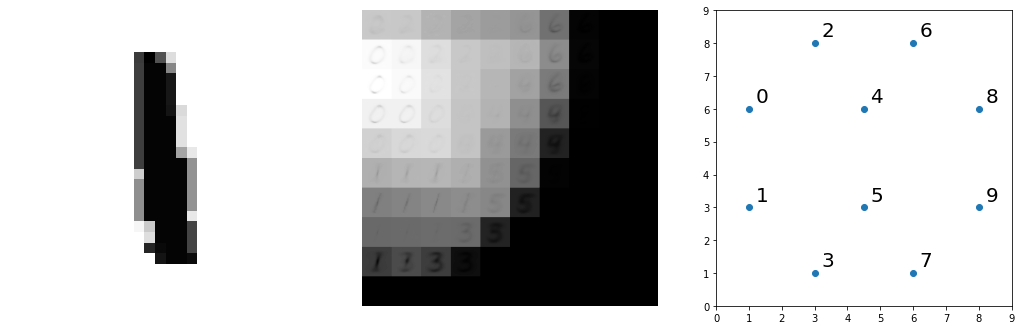

In [ ]:
# iterate epochs ----
losses = []
for epoch in range(epochs):
    np.random.shuffle(idcs)

    # learning rate and sigma annealing
    curr_sigma = initial_sigma*np.exp(-epoch/decay_window)
    curr_rl = initial_lr*np.exp(-epoch/decay_window)
    
    # update learning rate and sigma in the graph 
    keras.backend.set_value(model.get_layer("stm").sigma, curr_sigma)
    keras.backend.set_value(model.optimizer.lr, curr_rl)
    
    # iterate batches ----
    loss = []
    for batch in range(batches_num):
         
        # define current indices
        start_batch = batch * batch_size
        end_batch = (batch + 1) * batch_size
        curr_idcs = idcs[start_batch:end_batch]

        # define current the radial bases of the positions 
        # of the targets for each item in the batch
        targets = y_train[curr_idcs]  
        target_distances = gauss(
            np.linalg.norm(
                grid.reshape(1, out_num, 2) - 
                points[targets].reshape(-1, 1, 2), axis=-1), 
            curr_sigma)
        
        # train
        loss_ = model.train_on_batch([data[curr_idcs], target_distances])
        loss.append(loss_)

    losses.append(np.mean(loss))
    # update plot ----
    if epoch % 20 == 0 or epoch == epochs -1:

        # get current weights  
        weights = model.get_layer('stm').kernel.numpy()
        # reshape weights so to obtain a matrix of matrices (the actual prototypes)
        weights = weights.reshape(inp_side, inp_side, out_side, out_side)\
            .transpose(2,0,3,1).reshape(inp_side*out_side, inp_side*out_side)  
        digit.set_data(data[idcs[idx]])
        
        # update digit plot
        digit.set_clim(data[idcs[idx]].min(),data[idcs[idx]].max())
        #update weights plot
        w.set_data(weights)
        w.set_clim(weights.min(),weights.max())
        
        # display
        clear_output()
        print("epoch: ", epoch)
        print("loss:", losses[epoch])
        display(fig)
        
clear_output()
display(fig)


In [ ]:
clear_output()
plt.figure(figsize=(8,8))
side = 10
ratio = out_side // side
side_rnd = 7

points = np.random.rand(side_rnd*side_rnd,2)*10
points = points.astype("float32")

outs = RBF2DInterpolation(points, 0.7, side*side).numpy()
generated = model.backward_spread(outs)

for x in range(side_rnd):
    for y in range(side_rnd): 
        
        plt.subplot(side_rnd, side_rnd, x + y*side_rnd +1)
        plt.imshow(generated[x*side_rnd + y], cmap=plt.cm.Greys)
        plt.axis("off")
plt.show()